# EE 344 — Assignment 5: Power-System Fault Classification with Deep Neural Networks

In this assignment, you will predict **power-system fault conditions** from 6 input measurements using **PyTorch**.
There are many ways to implement DNNs for prediction tasks; here you will implement and compare **three** common setups.

**Dataset**: `classData.csv`

**Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`  
**Outputs**: 4-bit label `[G, C, B, A]`

Dataset (Kaggle): https://www.kaggle.com/datasets/esathyaprakash/electrical-fault-detection-and-classification

**Note:** Do **NOT** download the dataset from Kaggle. Use the dataset file provided on Canvas with this assignment.

Your tasks:
1. **Part 1** — Regression-style DNN to predict 4 outputs (then round to bits).
2. **Part 2** — Multi-label DNN to predict 4 bits (sigmoid / BCE-style loss).
3. **Part 3** — Multi-class DNN to predict no fault and 5 fault types (softmax / cross-entropy).
4. **Part 4** — Brief discussion: which approach is best and why.
5. **Part 5** — Open-ended: build a **binary** classifier (Fault vs No Fault) using the best approach.


## Setup
Run the next cell to import libraries and define helper functions.

In [77]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def plot_cm(cm, title, labels):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def bit_reports(Y_true_bits, Y_pred_bits, split_name='Test', bit_names=('G','C','B','A')):
    """Multi-label report + per-bit 2x2 confusion matrices."""
    print(f"\n=== Bit-level Report | {split_name} ===")
    print(classification_report(Y_true_bits, Y_pred_bits, target_names=list(bit_names), digits=4))
    for j, lab in enumerate(bit_names):
        cm = confusion_matrix(Y_true_bits[:, j], Y_pred_bits[:, j], labels=[0, 1])
        print(f"\nBit {lab} | {split_name} CM (rows=true 0/1, cols=pred 0/1):\n{cm}")

Device: cpu


## Dataset

The file `classData.csv` contains a dataset for classifying fault conditions.

- **Inputs**: `[Ia, Ib, Ic, Va, Vb, Vc]`
- **Outputs**: `[G, C, B, A]`

Examples:
- `[0 0 0 0]` — No Fault
- `[1 0 0 1]` — LG fault (Phase A to ground)
- `[0 0 1 1]` — LL fault (Phase A to Phase B)
- `[1 0 1 1]` — LLG fault (Phases A,B to ground)
- `[0 1 1 1]` — LLL fault (all three phases)
- `[1 1 1 1]` — LLLG fault (three phases + ground)


In [78]:
# ----------------------------
# Load data + create targets
# ----------------------------
CSV_PATH = 'classData.csv'
df = pd.read_csv(CSV_PATH)

label_cols = ['G','C','B','A']
feature_cols = ['Ia','Ib','Ic','Va','Vb','Vc']

missing = [c for c in (label_cols + feature_cols) if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}. Found: {list(df.columns)}")

X = df[feature_cols].astype(np.float32).values            # (N,6)
Y_bits = df[label_cols].astype(int).values                # (N,4)

FAULT_NAMES = ['No Fault','LG','LL','LLG','LLL','LLLG']

def bits_to_fault_type_idx(bits_gcba):
    G, C, B, A = map(int, bits_gcba)
    n_phase = C + B + A
    if G == 0 and n_phase == 0: return 0
    if G == 1 and n_phase == 1: return 1
    if G == 0 and n_phase == 2: return 2
    if G == 1 and n_phase == 2: return 3
    if G == 0 and n_phase == 3: return 4
    if G == 1 and n_phase == 3: return 5
    raise ValueError(f"Unexpected pattern [G,C,B,A]={bits_gcba}")

y_fault = np.array([bits_to_fault_type_idx(row) for row in Y_bits], dtype=int)
print('Fault counts:', dict(zip(FAULT_NAMES, np.bincount(y_fault, minlength=len(FAULT_NAMES)))))

# One shared split (recommended for fair comparison across Parts 1–3)
X_train, X_test, Y_train, Y_test, y_fault_train, y_fault_test = train_test_split(
    X, Y_bits, y_fault, test_size=0.30, random_state=RANDOM_STATE, stratify=y_fault
)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])


Fault counts: {'No Fault': np.int64(2365), 'LG': np.int64(1129), 'LL': np.int64(1004), 'LLG': np.int64(1134), 'LLL': np.int64(1096), 'LLLG': np.int64(1133)}
Train size: 5502 | Test size: 2359


## Part 1 — DNN Model 1 (Regression-style 4-output model)

You will build a DNN that outputs **4 real-valued numbers** and train it with **MSE**.
During evaluation, you will **round** predictions to the nearest integer, clamp to `{0,1}`, and then compare against the true 4-bit label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 (linear)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**


In [79]:
# ----------------------------
# Part 1: Robust scaling (fit on train only)
# ----------------------------
scaler_1 = RobustScaler()
X_train_s1 = scaler_1.fit_transform(X_train).astype(np.float32)
X_test_s1  = scaler_1.transform(X_test).astype(np.float32)

# Torch datasets
Xtr = torch.from_numpy(X_train_s1)
Xte = torch.from_numpy(X_test_s1)
Ytr = torch.from_numpy(Y_train.astype(np.float32))
Yte = torch.from_numpy(Y_test.astype(np.float32))

BATCH_SIZE = 256
train_loader_1 = DataLoader(TensorDataset(Xtr, Ytr), batch_size=BATCH_SIZE, shuffle=True)

# Hyperparameters
INPUT_DIM = 6
H1 = 16
H2 = 8
OUT_DIM = 4
DROPOUT_P = 0.25
L2_WEIGHT_DECAY = 1e-4
LR = 1e-3
EPOCHS = 1000


In [80]:
## [ TODO 1 ]
# Define the DNN for Part 1 using PyTorch.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: linear (no activation)
# - Use BatchNorm and Dropout in hidden layers
#
# Write your model class below.

class DNN_Reg4(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers (Linear, BatchNorm1d, Dropout, etc.)
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.drop1 = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop2 = nn.Dropout(p_drop)
        self.out = nn.Linear(h2, out_dim)
        self.relu = nn.ReLU()
        #pass

    def forward(self, x):
        # TODO: implement forward pass
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.drop2(x)
        x = self.out(x)
        return x
        #pass


In [81]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: MSE
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

# model = DNN_Reg4(...).to(device)
# loss_fn = ...
# optimizer = ...

model_1 = DNN_Reg4().to(device)
loss_fn_1 = nn.MSELoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

In [82]:
# ----------------------------
# Training loop (you fill the key missing pieces)
# ----------------------------
## [ TODO 3 ]
def train_part1(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        #total = 0.0          # I changed its name to total_loss so its more clear
        total_loss = 0.0

        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            # TODO: forward pass
            # TODO: compute loss
            # TODO: backward
            # TODO: optimizer step
            # total += loss.item() * xb.size(0)
            optimizer_1.zero_grad()
            pred = model(xb)
            loss = loss_fn_1(pred, yb)
            loss.backward()
            optimizer_1.step()
            total_loss += loss.item() * xb.size(0)
            #pass


        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            avg_loss = total_loss / len(loader.dataset)
            print(f'Epoch {ep:4d} | Loss: {avg_loss:.6f}')
            #pass

train_part1(model_1, train_loader_1)

@torch.no_grad()
def predict_part1(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    out = model(X_t).cpu().numpy()  # (N,4) real-valued

    return out

# TODO: Train the model



Epoch    1 | Loss: 0.766126
Epoch  500 | Loss: 0.103043
Epoch 1000 | Loss: 0.102669


In [83]:
# ----------------------------
# Evaluation (round -> clamp to {0,1} -> report)
# ----------------------------

yhat_train = predict_part1(model_1, X_train_s1)
yhat_test  = predict_part1(model_1, X_test_s1)

# After you obtain yhat_* (shape N x 4):
pred_bits_train = np.clip(np.rint(yhat_train).astype(int), 0, 1)
pred_bits_test  = np.clip(np.rint(yhat_test ).astype(int), 0, 1)
bit_reports(Y_train, pred_bits_train, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8870    0.7825    0.8315      2377
           C     0.9919    0.9178    0.9534      2263
           B     0.9458    0.9653    0.9555      3057
           A     0.9778    0.9803    0.9790      3144

   micro avg     0.9529    0.9197    0.9360     10841
   macro avg     0.9506    0.9115    0.9298     10841
weighted avg     0.9518    0.9197    0.9347     10841
 samples avg     0.6602    0.6496    0.6491     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2888  237]
 [ 517 1860]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3222   17]
 [ 186 2077]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2276  169]
 [ 106 2951]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2288   70]
 [  62 3082]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.8900    0.7704    0.8259      1019
           C     0.9856    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

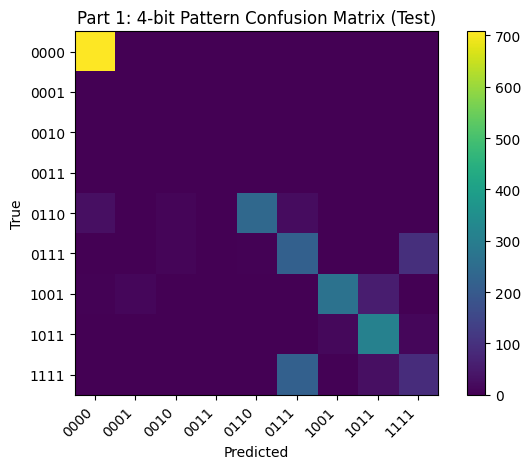

[[708   1   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [ 28   0  11   0 238  24   0   0   0]
 [  0   0  11   0   4 218   0   0  96]
 [  3  12   0   0   0   0 268  56   0]
 [  0   0   0   1   0   0  14 312  13]
 [  0   0   0   0   0 218   4  29  89]]


In [84]:
# One confusion matrix over full 4-bit patterns (for TEST set)
true_str = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str = [''.join(map(str, r.tolist())) for r in pred_bits_test]
labels = sorted(list(set(true_str) | set(pred_str)))
cm = confusion_matrix(true_str, pred_str, labels=labels)
plot_cm(cm, 'Part 1: 4-bit Pattern Confusion Matrix (Test)', labels)
print(cm)

## Part 2 — DNN Model 2 (Multi-label 4-bit classification)

You will build a DNN that predicts the 4 bits `[G, C, B, A]` as a **multi-label** output.
Each output dimension is an independent binary label.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 4 logits (apply sigmoid only for evaluation)
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use a **binary cross-entropy style loss on logits** (do not apply sigmoid inside the model).


In [98]:
# ----------------------------
# Part 2: Robust scaling (fit on train only)
# ----------------------------
scaler_2 = RobustScaler()
X_train_s2 = scaler_2.fit_transform(X_train).astype(np.float32)
X_test_s2  = scaler_2.transform(X_test).astype(np.float32)

Xtr2 = torch.from_numpy(X_train_s2)
Xte2 = torch.from_numpy(X_test_s2)
Ytr2 = torch.from_numpy(Y_train.astype(np.float32))
Yte2 = torch.from_numpy(Y_test.astype(np.float32))

train_loader_2 = DataLoader(TensorDataset(Xtr2, Ytr2), batch_size=BATCH_SIZE, shuffle=True)
test_loader_2  = DataLoader(TensorDataset(Xte2, Yte2), batch_size=BATCH_SIZE, shuffle=False)


In [100]:
## [ TODO 1 ]
# Define the DNN for Part 2.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 4
# - Hidden activations: ReLU
# - Output: 4 logits (no sigmoid inside the model)
# - Use BatchNorm and Dropout in hidden layers

# class DNN_MultiLabel4(nn.Module):
#     def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, out_dim=OUT_DIM, p_drop=DROPOUT_P):
#         super().__init__()
#         # TODO: define layers
#         self.fc1 = nn.Linear(input_dim, h1)
#         self.bn1 = nn.BatchNorm1d(h1)
#         self.drop1 = nn.Dropout(p_drop)
#         self.fc2 = nn.Linear(h1, h2)
#         self.bn2 = nn.BatchNorm1d(h2)
#         self.drop2 = nn.Dropout(p_drop)
#         self.out = nn.Linear(h2, out_dim)
#         self.relu = nn.ReLU()
#         #pass

#     def forward(self, x):
#         # TODO: forward pass returning logits (N,4)
#         x = self.fc1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.drop1(x)
#         x = self.fc2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.drop2(x)
#         x = self.out(x)
#         #pass


## Debug re-write:

class DNN_MultiLabel4(nn.Module):
    def __init__(self, input_dim=6, h1=16, h2=8, output_dim=4):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)
        return x



In [101]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: binary cross-entropy style loss on logits -- BCEWithLogitsLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

model_2 = DNN_MultiLabel4().to(device)
loss_fn_2 = nn.BCEWithLogitsLoss()
#optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)

optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=LR)


In [103]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3]

# def train_part2(model, loader, epochs=EPOCHS):
#     model.train()
#     for ep in range(1, epochs + 1):
#         #total = 0.0
#         total_loss = 0.0

#         for xb, yb in loader:

#             if yb is None:
#                 raise RuntimeError("Loader returned None for targets!")

#             xb = xb.to(device)
#             yb = yb.to(device)


#             print(type(yb))


#             # TODO: zero gradients
#             # TODO: logits = model(xb)
#             # TODO: loss = loss_fn(logits, yb)
#             # TODO: backward + step
#             optimizer_2.zero_grad()
#             logits = model(xb)
#             loss = loss_fn_2(logits, yb)
#             loss.backward()
#             optimizer_2.step()

#             # total += loss.item() * xb.size(0)
#             total_loss += loss.item() * xb.size(0)

#             #pass

#         if ep in [1, epochs//2, epochs]:
#             # TODO: print epoch + average loss
#             avg_loss = total_loss / len(loader.dataset)
#             print(f'Epoch {ep:4d} | Loss: {avg_loss:.6f}')
#             #pass


# -- Debug re-write
def train_part2(model, loader, epochs=EPOCHS):
    model.train()

    for ep in range(1, epochs + 1):
        total_loss = 0.0

        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer_2.zero_grad()
            logits = model(xb)
            loss = loss_fn_2(logits, yb) # yb should be float tensor of shape (batch, 4)
            loss.backward()
            optimizer_2.step()

            total_loss += loss.item() * xb.size(0)

        if ep in [1, epochs//2, epochs]:
            avg_loss = total_loss / len(loader.dataset)
            print(f'Epoch {ep:4d} | Loss: {avg_loss:.6f}')


# TODO: Train the model
train_part2(model_2, train_loader_2)

## Prediction function (sigmoid + threshold)
@torch.no_grad()
def predict_bits_part2(model, X_np, threshold=0.5):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    probs = torch.sigmoid(logits).cpu().numpy()
    pred_bits = (probs >= threshold).astype(int)
    return pred_bits



Epoch    1 | Loss: 0.102190
Epoch  500 | Loss: 0.062900
Epoch 1000 | Loss: 0.056085


In [104]:
# ----------------------------
# Evaluation
# ----------------------------
pred_bits_train_ = predict_bits_part2(model_2, X_train_s2)
pred_bits_test_  = predict_bits_part2(model_2, X_test_s2)

bit_reports(Y_train, pred_bits_train_, split_name='Train', bit_names=label_cols)
bit_reports(Y_test,  pred_bits_test_,  split_name='Test',  bit_names=label_cols)


=== Bit-level Report | Train ===
              precision    recall  f1-score   support

           G     0.8059    0.9361    0.8661      2377
           C     0.9996    0.9863    0.9929      2263
           B     0.9997    0.9944    0.9970      3057
           A     0.9984    1.0000    0.9992      3144

   micro avg     0.9514    0.9816    0.9663     10841
   macro avg     0.9509    0.9792    0.9638     10841
weighted avg     0.9568    0.9816    0.9681     10841
 samples avg     0.6745    0.6897    0.6796     10841


Bit G | Train CM (rows=true 0/1, cols=pred 0/1):
[[2589  536]
 [ 152 2225]]

Bit C | Train CM (rows=true 0/1, cols=pred 0/1):
[[3238    1]
 [  31 2232]]

Bit B | Train CM (rows=true 0/1, cols=pred 0/1):
[[2444    1]
 [  17 3040]]

Bit A | Train CM (rows=true 0/1, cols=pred 0/1):
[[2353    5]
 [   0 3144]]

=== Bit-level Report | Test ===
              precision    recall  f1-score   support

           G     0.7947    0.9195    0.8526      1019
           C     1.0000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

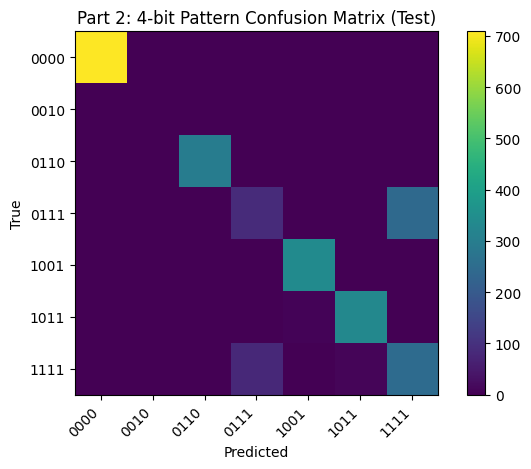

[[709   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   2 297   2   0   0   0]
 [  0   0   0  87   0   0 242]
 [  0   0   0   0 339   0   0]
 [  0   0   0   0   8 332   0]
 [  0   0   0  82   0  10 248]]


In [105]:
# One confusion matrix over full 4-bit patterns (For TEST set)
true_str_ = [''.join(map(str, r.tolist())) for r in Y_test]
pred_str_ = [''.join(map(str, r.tolist())) for r in pred_bits_test_]
labels_ = sorted(list(set(true_str_) | set(pred_str_)))
cm_ = confusion_matrix(true_str_, pred_str_, labels=labels_)
plot_cm(cm_, 'Part 2: 4-bit Pattern Confusion Matrix (Test)', labels_)
print(cm_)

## Part 3 — DNN Model 3 (Multi-class fault type classification)

In this part, you will predict one of **6 fault types**.
The 4-bit label is converted to a single class in `{0,1,2,3,4,5}` using the provided mapping.

Model structure:
- Input: 6 features
- Hidden: 16 → 8 (ReLU)
- Output: 6 logits
- Include: **BatchNorm**, **Dropout**, and **L2 regularization**

Training:
- Use **cross-entropy loss** for multi-class classification.


In [90]:
# ----------------------------
# Part 3: Robust scaling (fit on train only)
# ----------------------------
scaler_3 = RobustScaler()
X_train_s3 = scaler_3.fit_transform(X_train).astype(np.float32)
X_test_s3  = scaler_3.transform(X_test).astype(np.float32)

ytr3 = torch.from_numpy(y_fault_train.astype(np.int64))
yte3 = torch.from_numpy(y_fault_test.astype(np.int64))
Xtr3 = torch.from_numpy(X_train_s3)
Xte3 = torch.from_numpy(X_test_s3)

train_loader_3 = DataLoader(TensorDataset(Xtr3, ytr3), batch_size=BATCH_SIZE, shuffle=True)


In [91]:
## [ TODO 1 ]
# Define the DNN for Part 3.
# Requirements:
# - Architecture: 6 -> 16 -> 8 -> 6
# - Hidden activations: ReLU
# - Output: 6 logits
# - Use BatchNorm and Dropout in hidden layers

class DNN_MultiClass6(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, h1=H1, h2=H2, num_classes=6, p_drop=DROPOUT_P):
        super().__init__()
        # TODO: define layers
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.drop1 = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop2 = nn.Dropout(p_drop)
        self.out = nn.Linear(h2, num_classes)
        self.relu = nn.ReLU()
        #pass

    def forward(self, x):
        # TODO: forward pass returning logits (N,6)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.drop2(x)
        x = self.out(x)
        return x
        #pass


In [92]:
## [ TODO 2 ]
# Create the model, loss function, and optimizer.
# Requirements:
# - Loss: CrossEntropyLoss
# - Optimizer: Adam
# - Include L2 regularization using weight_decay

# TODO: model = ...
# TODO: loss_fn = ...
# TODO: optimizer = ...

model_3 = DNN_MultiClass6().to(device)
loss_fn_3 = nn.CrossEntropyLoss()
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=LR, weight_decay=L2_WEIGHT_DECAY)


In [93]:
# ----------------------------
# Training loop scaffold
# ----------------------------
## [ TODO 3 ]
def train_part3(model, loader, epochs=EPOCHS):
    model.train()
    for ep in range(1, epochs + 1):
        total = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # TODO: zero gradients
            # TODO: logits = model(xb)
            # TODO: loss = loss_fn(logits, yb)
            # TODO: backward + step
            optimizer_3.zero_grad()
            logits = model(xb)
            loss = loss_fn_3(logits, yb)   # yb are class indices (Long)
            loss.backward()
            optimizer_3.step()
            total += loss.item() * xb.size(0)
            #pass

        if ep in [1, epochs//2, epochs]:
            # TODO: print epoch + average loss
            avg_loss = total / len(loader.dataset)
            print(f'Epoch {ep:4d} | Loss: {avg_loss:.6f}')
            pass

# TODO: Train the model
train_part3(model_3, train_loader_3)

@torch.no_grad()
def predict_part3(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np.astype(np.float32)).to(device)
    logits = model(X_t)
    return torch.argmax(logits, dim=1).cpu().numpy()


Epoch    1 | Loss: 1.841692
Epoch  500 | Loss: 0.645856
Epoch 1000 | Loss: 0.638901



=== Part 3 | Train ===
              precision    recall  f1-score   support

    No Fault     0.9555    1.0000    0.9773      1655
          LG     0.8359    0.9481    0.8885       790
          LL     0.9196    0.9431    0.9312       703
         LLG     0.8858    0.8690    0.8773       794
         LLL     0.5135    0.8683    0.6453       767
        LLLG     0.4156    0.0404    0.0736       793

    accuracy                         0.8097      5502
   macro avg     0.7543    0.7781    0.7322      5502
weighted avg     0.7843    0.8097    0.7677      5502



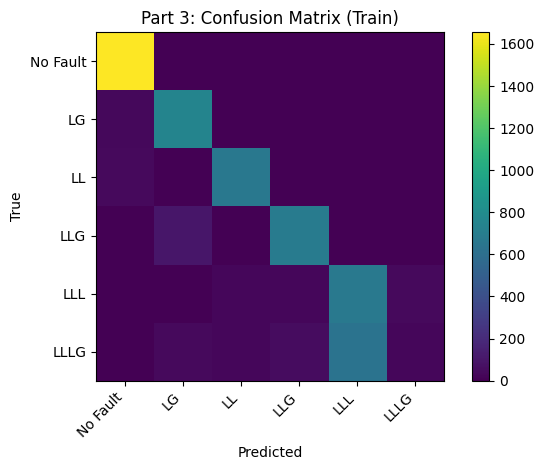


=== Part 3 | Test ===
              precision    recall  f1-score   support

    No Fault     0.9479    1.0000    0.9733       710
          LG     0.8312    0.9440    0.8840       339
          LL     0.9338    0.9369    0.9353       301
         LLG     0.9193    0.8706    0.8943       340
         LLL     0.5095    0.8967    0.6498       329
        LLLG     0.4091    0.0265    0.0497       340

    accuracy                         0.8105      2359
   macro avg     0.7585    0.7791    0.7311      2359
weighted avg     0.7864    0.8105    0.7660      2359



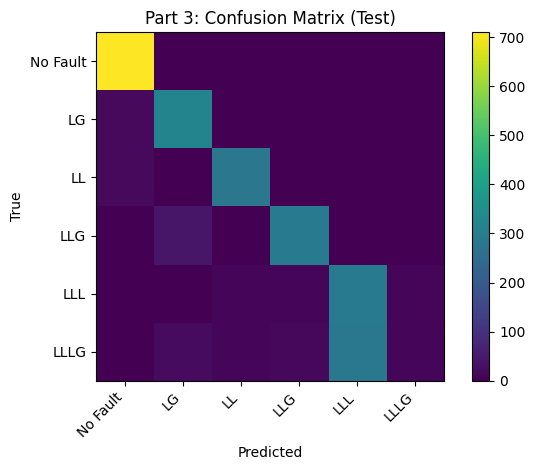

In [94]:
# ----------------------------
# Evaluation
# ----------------------------
pred_train = predict_part3(model_3, X_train_s3)
pred_test  = predict_part3(model_3, X_test_s3)

print('\n=== Part 3 | Train ===')
print(classification_report(y_fault_train, pred_train, target_names=FAULT_NAMES, digits=4))
cm_tr = confusion_matrix(y_fault_train, pred_train, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_tr, 'Part 3: Confusion Matrix (Train)', FAULT_NAMES)

print('\n=== Part 3 | Test ===')
print(classification_report(y_fault_test, pred_test, target_names=FAULT_NAMES, digits=4))
cm_te = confusion_matrix(y_fault_test, pred_test, labels=np.arange(len(FAULT_NAMES)))
plot_cm(cm_te, 'Part 3: Confusion Matrix (Test)', FAULT_NAMES)


## Part 4 — Discussion

Answer **2–5 sentences** for each prompt.

1. Compare Parts 1–3. Which formulation fits this dataset best (regression-style, multi-label, or multi-class), and why?
2. When you used the bit-based approaches (Part 1 and Part 2), did you observe any **inconsistent 4-bit outputs** (invalid fault patterns)? What does that suggest?
3. Looking at confusion matrices, which fault types (or bit positions) were the hardest to predict? Give one plausible reason.

### My answers
- Q1: The multi-label approach at Part 2 fits this dataset the best. Shown at the results, Part 2 achieves near-perfect classification with test F1-scores of 0.9938, 0.9966, and 0.9993 for bits C, B, and A respectively, and a strong 0.8526 for bit G. The 4-bit pattern confusion matrix is heavily diagonal, indicating it almost always predicts the exact correct fault pattern. Part 1 (regression-style) performs not bad but worse than Part 2, with lower F1-scores across all bits and more off-diagonal errors in its pattern matrix. Part 3 (multi-class) struggles significantly with LLL and LLLG faults (F1-scores of 0.6498 and 0.0497 on test), despite decent performance on other classes. The multi-label formulation we used in Part 2 is best because it directly models each output bit as an independent binary task, which aligns perfectly with the dataset's structure where each fault type is defined by a specific combination of four independent bits.

- Q2: Yes, both bit-based approaches produced some inconsistent 4-bit patterns. In Part 1's test confusion matrix, we can see that predictions like patterns that don't match any of the six valid fault types. For example, some samples were predicted as patterns that don't correspond to any defined fault in the mapping. Even in Part 2's highly accurate results, there are still a few off-diagonal predictions where the model output a 4-bit combination that are not present in the training data. This suggests that treating the bits independently allows the model to generate any combination of 0s and 1s, even physically impossible ones. It highlights a limitation: the bit-based approaches don't inherently learn the correlation structure between bits (e.g., that certain bits tend to co-occur in specific ways) and may occasionally produce invalid fault patterns that wouldn't occur in reality.

- Q3: For bit positions, bit G (ground fault) was the hardest to predict in both Part 1 and Part 2. In Part 2's test results, bit G has noticeably lower precision (0.7947) and recall (0.9195) compared to bits C, B, and A which are all near 1.0. The confusion matrix for bit G shows 242 false positives and 82 false negatives. For fault types in Part 3, the LLL (three-phase) and LLLG (three-phase-to-ground) faults were extremely difficult—LLL achieved only 0.5095 precision and 0.6498 F1-score, while LLLG performed disastrously with 0.4091 precision, 0.0265 recall, and 0.0497 F1-score. A plausible reason may be that these faults involve all three phases simultaneously, producing electrical signatures that may be very similar to each other or to other multi-phase faults. The subtle differences between having all three phases faulted with versus without ground might be hard for the model to distinguish, especially since these are the most complex fault types involving maximum phase involvement.


## Part 5 — Open-ended extension: Binary classification (Fault vs No Fault)

In this part, you will create a **binary** classification problem:

- Class 0: **No Fault** (`[0,0,0,0]`)
- Class 1: **Fault** (any other pattern)

**Your task**: Using the best formulation you identified in Part 4, build a DNN to classify **Fault vs No Fault**.

Requirements:
- Use a **70% / 30%** train/test split (stratified)
- Use **RobustScaler** (fit on train only)
- Report **classification report** and **confusion matrix** on **train and test**

Implementation notes:
- First create a dataset with two classes by compressing all fault types into a single “Fault” class (and keeping “No Fault” as the other class).
- Keep your solution clean and focused: data, model, training, evaluation.


Use the multi‑label model and infer “Fault” if any of the four bits is 1:


== Binary Classification (Fault vs No Fault) using multi-label model ==
              precision    recall  f1-score   support

    No Fault       1.00      1.00      1.00       710
       Fault       1.00      1.00      1.00      1649

    accuracy                           1.00      2359
   macro avg       1.00      1.00      1.00      2359
weighted avg       1.00      1.00      1.00      2359



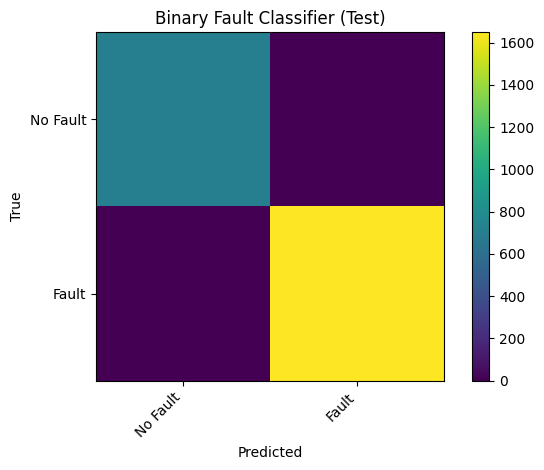

In [106]:
# Using model_2 from Part 2
pred_bits_test = predict_bits_part2(model_2, X_test_s2)
# Fault if any bit is 1
pred_fault = (pred_bits_test.sum(axis=1) > 0).astype(int)
true_fault = (Y_test.sum(axis=1) > 0).astype(int)

print("\n== Binary Classification (Fault vs No Fault) using multi-label model ==")
print(classification_report(true_fault, pred_fault, target_names=['No Fault', 'Fault']))
cm_bin = confusion_matrix(true_fault, pred_fault)
plot_cm(cm_bin, 'Binary Fault Classifier (Test)', ['No Fault', 'Fault'])